In [2]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stanford-earthquake-dataset-stead/merge.hdf5
/kaggle/input/stanford-earthquake-dataset-stead/merge.csv


In [3]:
file_path = '/kaggle/input/stanford-earthquake-dataset-stead/merge.csv'

In [4]:
df = pd.read_csv(file_path, low_memory=False)
src_df = df[df.source_distance_km > 0]

In [5]:
src_df.shape

(1030229, 35)

In [6]:
!pip install h5py tqdm

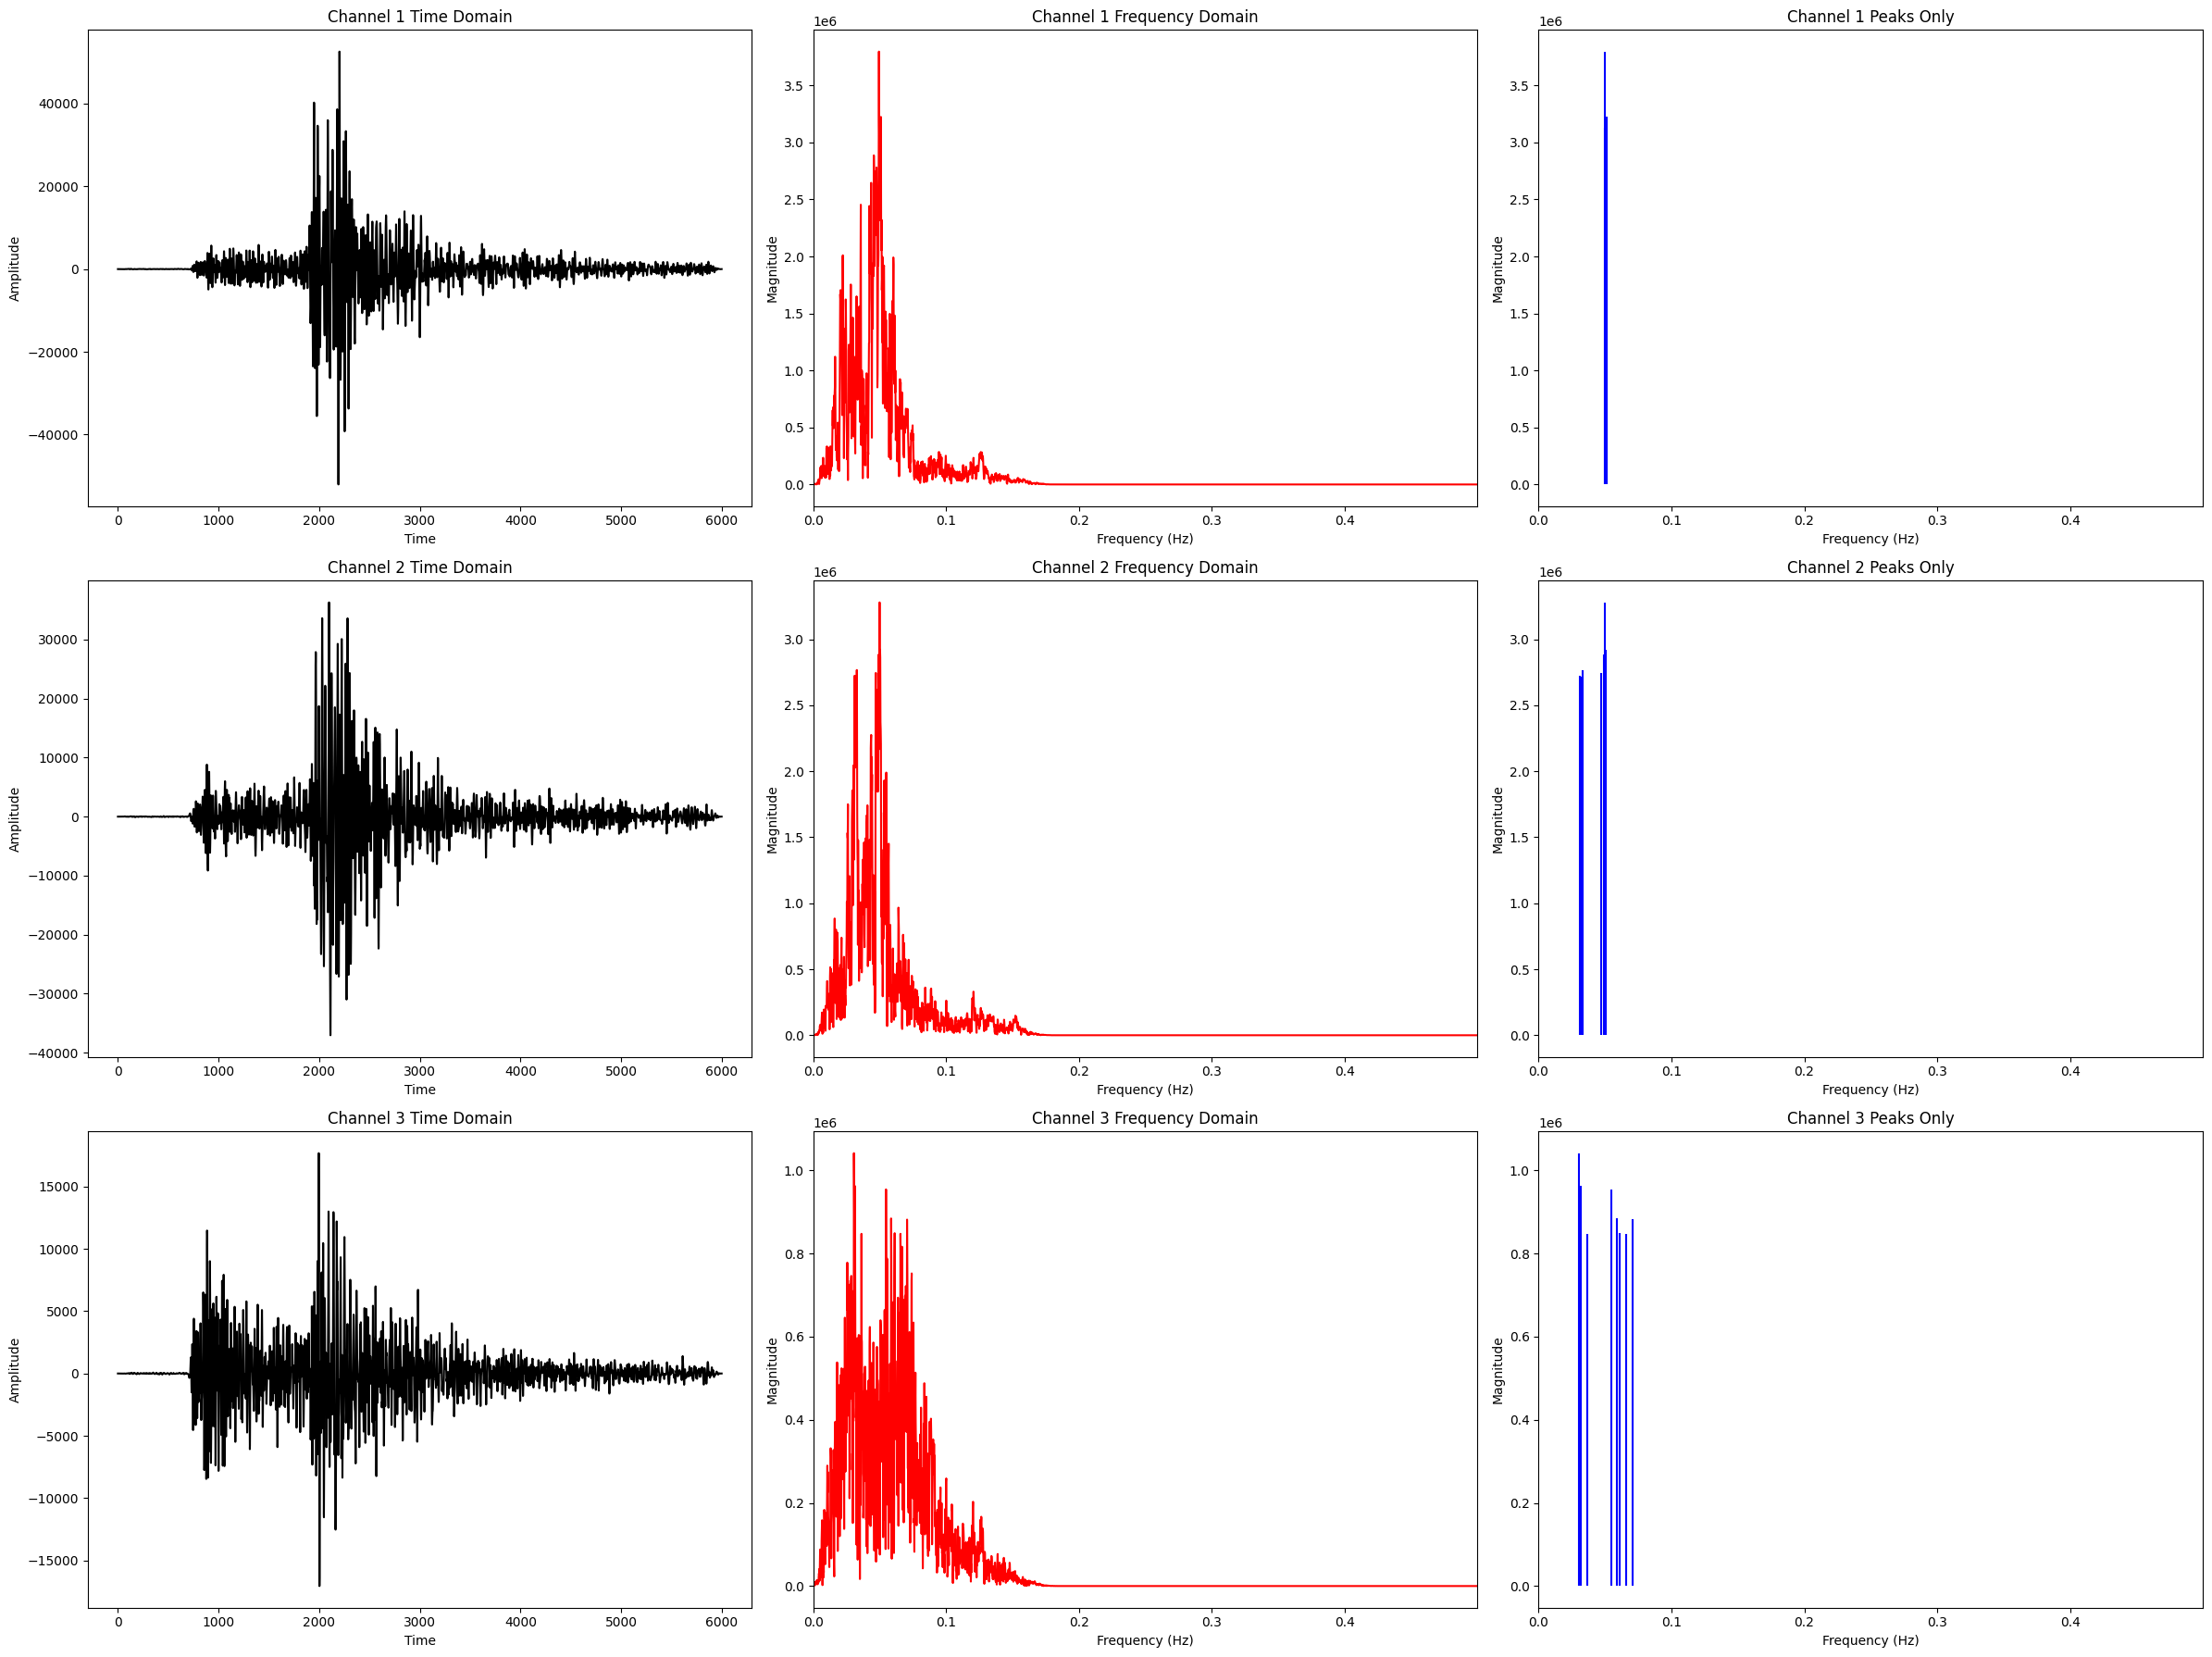

Peak frequencies for Channel 1: [0.0495 0.05   0.051 ]
Peak frequencies for Channel 2: [0.03116667 0.032      0.03233333 0.03283333 0.04716667 0.04933333
 0.05       0.05033333]
Peak frequencies for Channel 3: [0.03066667 0.0315     0.03633333 0.05483333 0.05866667 0.06133333
 0.06566667 0.07066667]
Metadata for 109C.TA_20060723155859_EV:
back_azimuth_deg: 159.3000030517578
coda_end_sample: [[2896.]]
network_code: TA
p_arrival_sample: 700.0
p_status: manual
p_travel_sec: 17.079999923706055
p_weight: 0.5
receiver_code: 109C
receiver_elevation_m: 150.0
receiver_latitude: 32.8889
receiver_longitude: -117.1051
receiver_type: BH
s_arrival_sample: 1894.0
s_status: manual
s_weight: 0.5
snr_db: [56.79999924 55.40000153 47.40000153]
source_depth_km: 0.44999998807907104
source_depth_uncertainty_km: None
source_distance_deg: 0.9200000166893005
source_distance_km: 102.08999633789062
source_error_sec: 1.111899971961975
source_gap_deg: 107.46600341796875
source_horizontal_uncertainty_km: 4.640299797

In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

ev_list = src_df['trace_name'].to_list()
file_name = "/kaggle/input/stanford-earthquake-dataset-stead/merge.hdf5"
dtfl = h5py.File(file_name, 'r')

for c, evi in enumerate(ev_list):
    dataset = dtfl.get('data/'+str(evi))
    if dataset:
        data = np.array(dataset)
        fft_data = np.fft.fft(data, axis=0)
        freq = np.fft.fftfreq(data.shape[0])

        positive_freq_indices = freq > 0
        positive_freqs = freq[positive_freq_indices]
        positive_fft_data = fft_data[positive_freq_indices]

        fig = plt.figure(figsize=(24, 18))

        all_peak_freqs = []  

        for i in range(3):  # E, N, Z channels
            ax = fig.add_subplot(3, 3, 3*i + 1)
            plt.plot(data[:, i], 'k')
            plt.title(f"Channel {i+1} Time Domain")
            plt.ylabel('Amplitude')
            plt.xlabel('Time')
            plt.tight_layout()

        max_freq = positive_freqs[-1]
        for i in range(3):
            ax = fig.add_subplot(3, 3, 3*i + 2)
            plt.plot(positive_freqs, np.abs(positive_fft_data[:, i]), 'r') 
            plt.xlim(0, max_freq)
            plt.title(f"Channel {i+1} Frequency Domain")
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude')
            plt.tight_layout()
            
        threshold = 0.8
        for i in range(3):
            ax = fig.add_subplot(3, 3, 3*i + 3)
            magnitude = np.abs(positive_fft_data[:, i])
            peaks, _ = find_peaks(magnitude, height=np.max(magnitude) * threshold)
            peak_freqs = positive_freqs[peaks]
            all_peak_freqs.append(peak_freqs)
            plt.vlines(peak_freqs, ymin=0, ymax=magnitude[peaks], color='b')
            plt.xlim(0, max_freq)
            plt.title(f"Channel {i+1} Peaks Only")
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude')
            plt.tight_layout()

        plt.show()

        for i, freqs in enumerate(all_peak_freqs):
            print(f"Peak frequencies for Channel {i+1}: {freqs}")

        print(f"Metadata for {evi}:")
        for key, value in dataset.attrs.items():
            print(f"{key}: {value}")

    break

In [8]:
import numpy as np
import h5py
from scipy.signal import find_peaks
from tqdm import tqdm

file_name = "/kaggle/input/stanford-earthquake-dataset-stead/merge.hdf5"
dtfl = h5py.File(file_name, 'r')
features = []
labels = []

idx = 0

for evi in tqdm(src_df['trace_name'].to_list(), total=10000):
    idx += 1
    dataset = dtfl.get('data/'+str(evi))
    if dataset:
        source_distance = dataset.attrs.get('source_distance_km', None)
        source_magnitude = dataset.attrs.get('source_magnitude', None)
        source_depth = dataset.attrs.get('source_depth_km', None)

        if source_distance in [None, 'None'] or source_magnitude in [None, 'None'] or source_depth in [None, 'None']:
            continue

        # Convert source attributes to float
        complete_feature_set = [
            float(source_distance),
            float(source_magnitude),
            float(source_depth)
        ]

        data = np.array(dataset)
        fft_data = np.fft.fft(data, axis=0)
        freq = np.fft.fftfreq(data.shape[0])

        positive_freq_indices = freq > 0
        positive_freqs = freq[positive_freq_indices]
        positive_fft_data = fft_data[positive_freq_indices]

        weighted_frequencies = []

        for i in range(3):
            fft_magnitude = np.abs(positive_fft_data[:, i])
            peaks, properties = find_peaks(fft_magnitude, height=np.max(fft_magnitude) * 0.9)
            if len(peaks) > 0:
                peak_freqs = positive_freqs[peaks]
                peak_mags = properties['peak_heights']
                weighted_avg = np.average(peak_freqs, weights=peak_mags)
                weighted_frequencies.append(weighted_avg)
            else:
                weighted_frequencies.append(0)

        features.append(complete_feature_set)
        labels.append([round(freq, 3) for freq in weighted_frequencies])
    
    if idx > 9999:
        break

features = np.array(features, dtype=float)
labels = np.array(labels, dtype=float)

print("Features example:", features[:10])
print("Labels example:", labels[:10])

100%|█████████▉| 9999/10000 [07:29<00:00, 22.26it/s]


Features example: [[102.08999634   3.6          0.44999999]
 [101.33999634   4.3          9.19999981]
 [101.87000275   3.6         12.65999985]
 [103.26000214   3.8         11.5       ]
 [102.48000336   3.6          7.26000023]
 [107.33999634   3.8          9.72999954]
 [108.02999878   4.1          2.0999999 ]
 [108.51999664   3.6          7.30999994]
 [106.69000244   3.9          2.05999994]
 [102.11000061   3.1         12.60000038]]
Labels example: [[0.049 0.05  0.039]
 [0.044 0.038 0.027]
 [0.049 0.033 0.03 ]
 [0.044 0.043 0.062]
 [0.047 0.05  0.062]
 [0.026 0.02  0.031]
 [0.026 0.034 0.027]
 [0.035 0.018 0.024]
 [0.023 0.039 0.023]
 [0.045 0.046 0.066]]


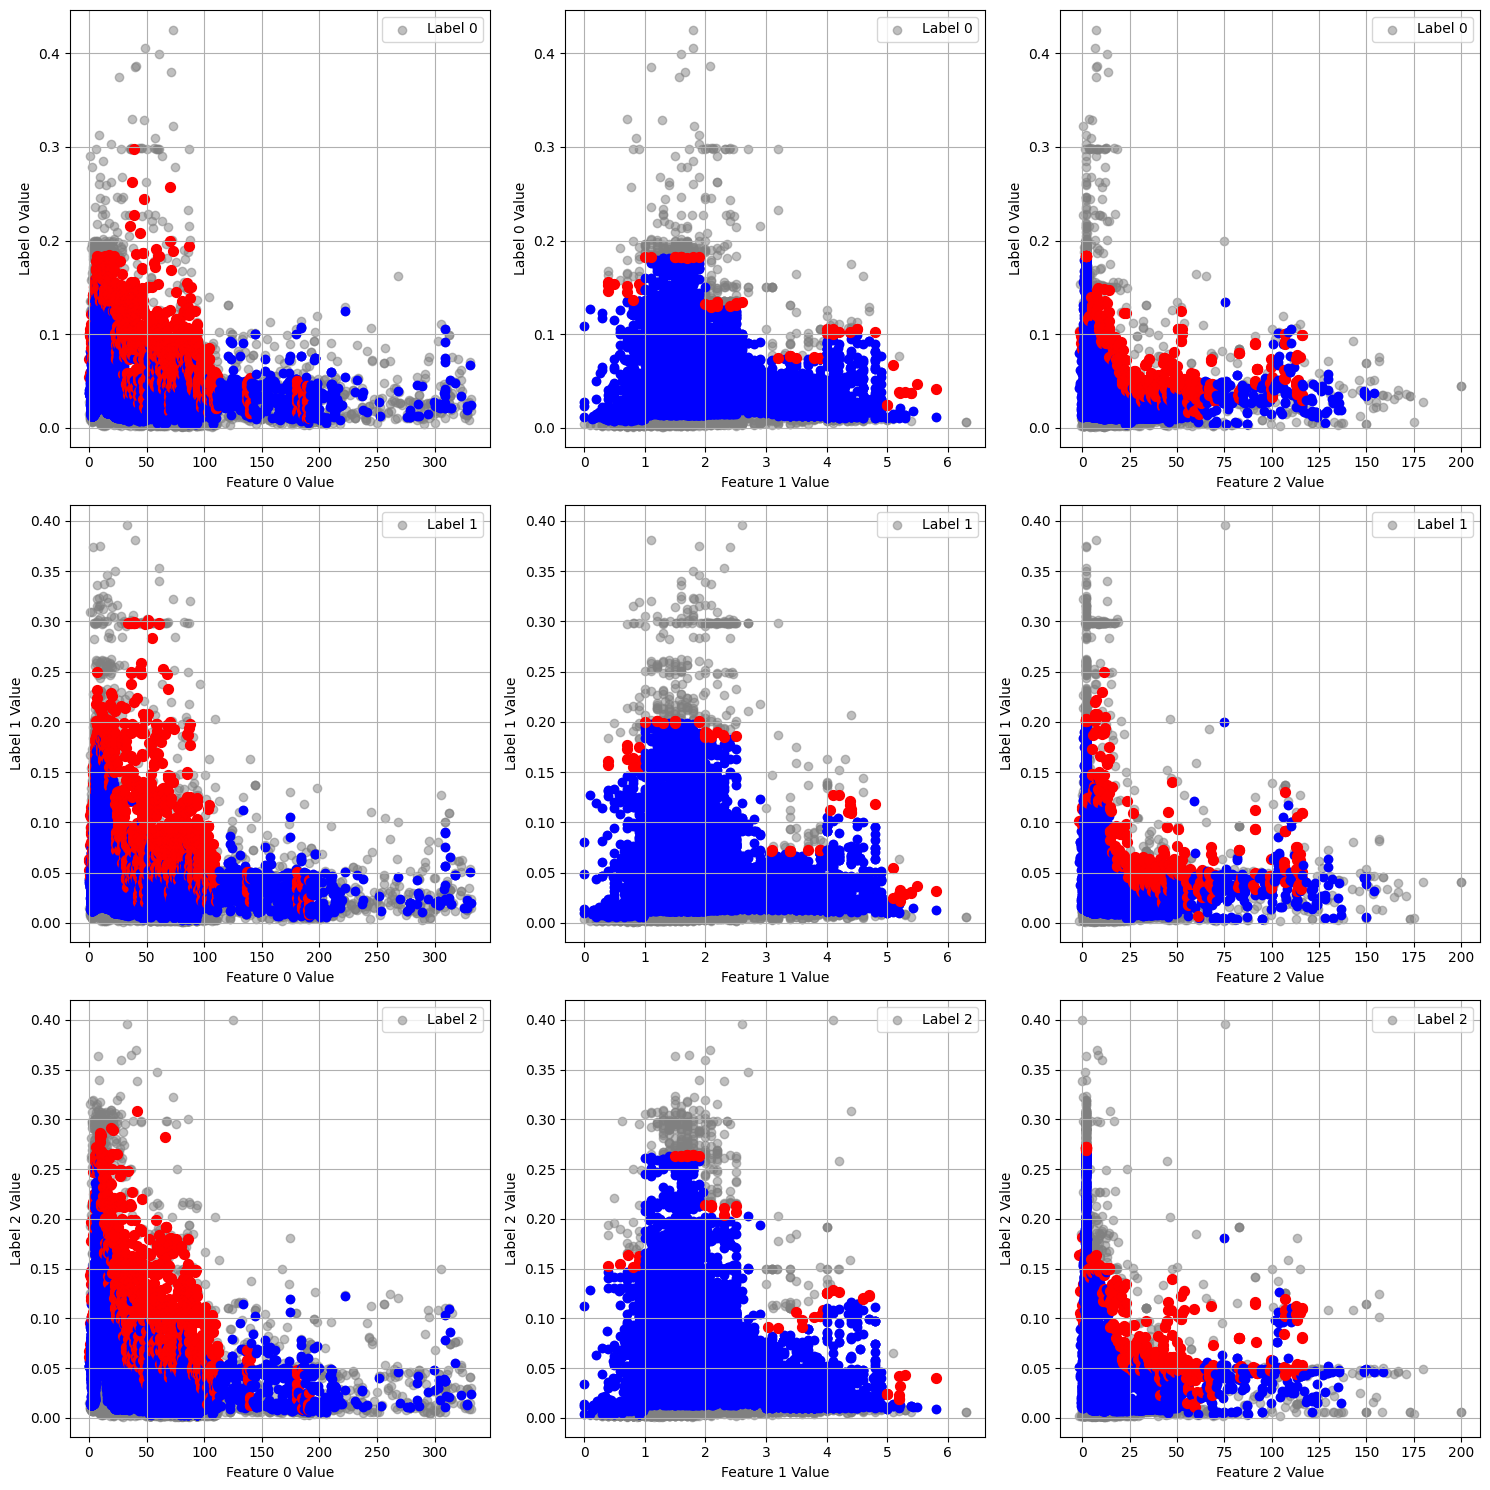

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import math

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

lower_percentile = 10
upper_percentile = 98

for i in range(3):
    for j in range(3):
        # Original scatter plot
        axs[i, j].scatter(features[:, j], labels[:, i], label=f'Label {i}', alpha=0.5, color='grey')

        min_value = np.min(features[:, j])
        max_value = np.max(features[:, j])
        range_width = max_value - min_value / 100

        for section in range(100):
            section_min = min_value + section * range_width
            section_max = section_min + range_width
            
            section_indices = (features[:, j] >= section_min) & (features[:, j] < section_max)
            section_features = features[section_indices, j]
            section_labels = labels[section_indices, i]

            if len(section_labels) > 1:
                low_limit = np.percentile(section_labels, lower_percentile)
                high_limit = np.percentile(section_labels, upper_percentile)
                clean_indices = (section_labels > low_limit) & (section_labels < high_limit)
                clean_features = section_features[clean_indices]
                clean_labels = section_labels[clean_indices]

                axs[i, j].scatter(clean_features, clean_labels, color='blue')

                if len(clean_labels) > 4:
                    top_indices = np.argsort(clean_labels)[-4:]
                    top_features = clean_features[top_indices]
                    top_labels = clean_labels[top_indices]

                    axs[i, j].scatter(top_features, top_labels, color='red', s=50)

        axs[i, j].set_xlabel(f'Feature {j} Value')
        axs[i, j].set_ylabel(f'Label {i} Value')
        axs[i, j].legend()
        axs[i, j].grid(True)

plt.tight_layout()
plt.show()

Iteration 1, loss = 12.76538682
Iteration 2, loss = 3.81636298
Iteration 3, loss = 1.79388041
Iteration 4, loss = 1.06230273
Iteration 5, loss = 0.54941009
Iteration 6, loss = 0.29471804
Iteration 7, loss = 0.13463612
Iteration 8, loss = 0.07434212
Iteration 9, loss = 0.05217444
Iteration 10, loss = 0.03118960
Iteration 11, loss = 0.01128561
Iteration 12, loss = 0.00934620
Iteration 13, loss = 0.00644034
Iteration 14, loss = 0.00514530
Iteration 15, loss = 0.00492411
Iteration 16, loss = 0.00449350
Iteration 17, loss = 0.00416508
Iteration 18, loss = 0.00391105
Iteration 19, loss = 0.00377298
Iteration 20, loss = 0.00359855
Iteration 21, loss = 0.00346207
Iteration 22, loss = 0.00334534
Iteration 23, loss = 0.00321653
Iteration 24, loss = 0.00314444
Iteration 25, loss = 0.00307356
Iteration 26, loss = 0.00310948
Iteration 27, loss = 0.00308033
Iteration 28, loss = 0.00301971
Iteration 29, loss = 0.00296465
Iteration 30, loss = 0.00299329
Iteration 31, loss = 0.00291005
Iteration 32, lo

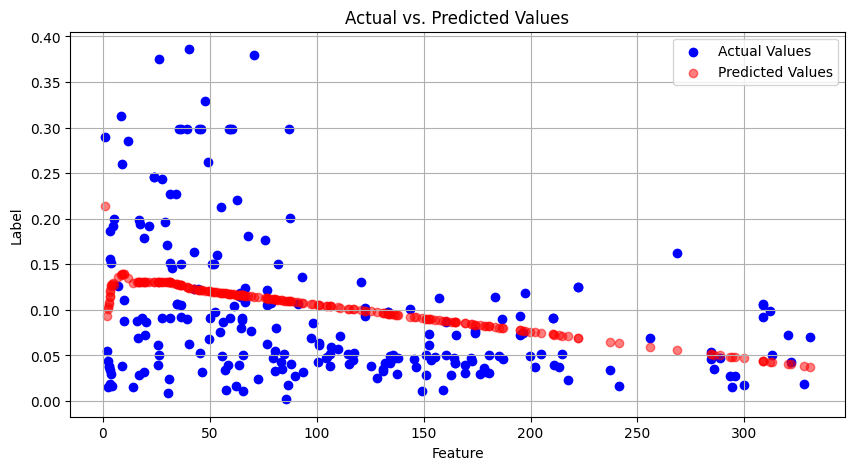

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

selected_features = []
selected_labels = []

for j in range(features.shape[1]):
    min_value = np.min(features[:, j])
    max_value = np.max(features[:, j])
    range_width = (max_value - min_value) / 200
    
    for section in range(200):
        section_min = min_value + section * range_width
        section_max = section_min + range_width

        section_indices = (features[:, j] >= section_min) & (features[:, j] < section_max)
        section_features = features[section_indices, :]
        section_labels = labels[section_indices, :]

        if section_labels.shape[0] > 3:
            top_indices = np.argsort(section_labels[:, j])[-3:]
            selected_features.append(section_features[top_indices])
            selected_labels.append(section_labels[top_indices])

selected_features = np.vstack(selected_features)
selected_labels = np.vstack(selected_labels)

X = selected_features[:, 0].reshape(-1, 1)
y = selected_labels[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nn = MLPRegressor(hidden_layer_sizes=(200, 100, 50), max_iter=500, activation='relu', solver='adam', random_state=42, verbose=True)
nn.fit(X_train, y_train)

y_pred = nn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

plt.figure(figsize=(10, 5))
plt.scatter(X_test, y_test, color='blue', label='Actual Values')
plt.scatter(X_test, y_pred, color='red', alpha=0.5, label='Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Feature')
plt.ylabel('Label')
plt.legend()
plt.grid(True)
plt.show()

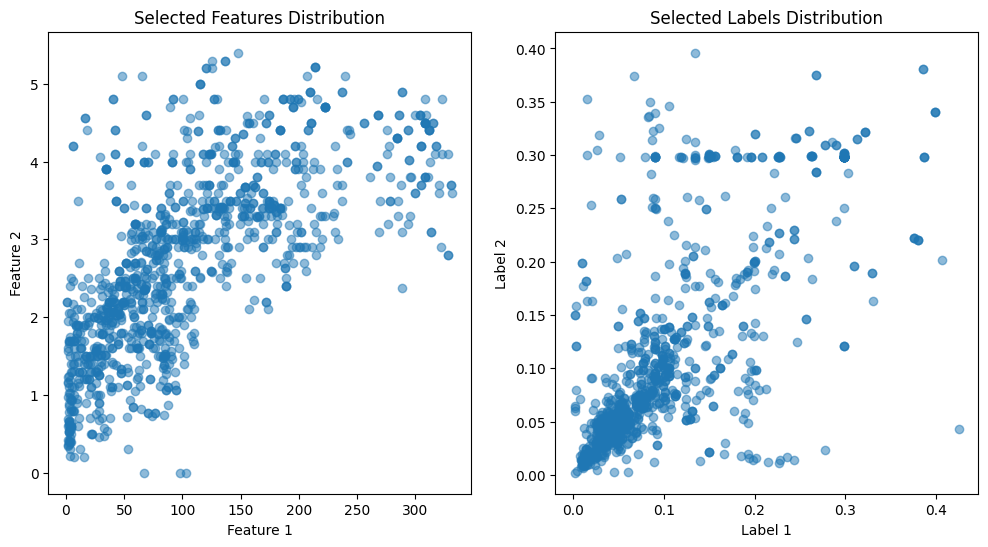

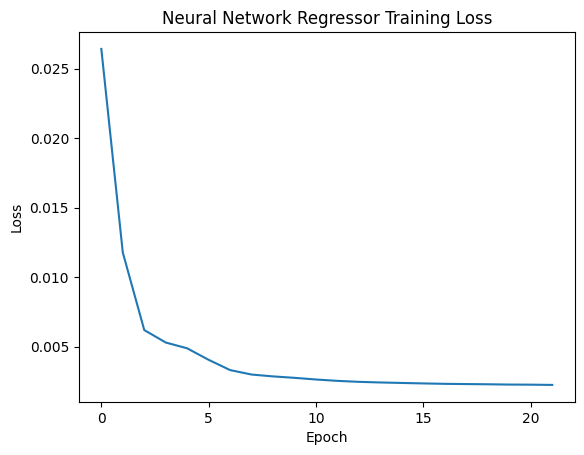

MSE Results:
Linear Regression: 0.005863702319740295
Ridge Regression: 0.005863708803167452
Lasso Regression: 0.005886419026681771
Support Vector Regression: 0.004554203845060928
Random Forest: 0.0020308198501805515
Extra Trees Regressor: 0.0020060123634900607
XGBoost Regressor: 0.0023757687007466724
Neural Network Regressor: 0.004366601122424895

Actual vs Predicted (first 5 samples):
Linear Regression Actual vs Predicted:
Actual: [0.069 0.04  0.03 ], Predicted: [0.09763026 0.1066646  0.10238598]
Actual: [0.031 0.051 0.052], Predicted: [0.06360937 0.06354609 0.06824485]
Actual: [0.087 0.314 0.098], Predicted: [0.1352785  0.1523828  0.13616052]
Actual: [0.049 0.046 0.074], Predicted: [0.0966862  0.10085406 0.09359562]
Actual: [0.064 0.123 0.055], Predicted: [0.10697611 0.11493787 0.10693736]
Ridge Regression Actual vs Predicted:
Actual: [0.069 0.04  0.03 ], Predicted: [0.09762935 0.10666375 0.10238611]
Actual: [0.031 0.051 0.052], Predicted: [0.06360767 0.0635445  0.0682451 ]
Actual: [

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Assuming features and labels are already defined

# Collect top max values for each section
selected_features = []
selected_labels = []

for j in range(features.shape[1]):  # For each feature
    min_value = np.min(features[:, j])
    max_value = np.max(features[:, j])
    range_width = (max_value - min_value) / 200
    
    for section in range(200):
        section_min = min_value + section * range_width
        section_max = section_min + range_width

        section_indices = (features[:, j] >= section_min) & (features[:, j] < section_max)
        section_features = features[section_indices, :]
        section_labels = labels[section_indices, :]

        if section_labels.shape[0] > 3:
            top_indices = np.argsort(section_labels[:, j])[-3:]
            selected_features.append(section_features[top_indices])
            selected_labels.append(section_labels[top_indices])

selected_features = np.vstack(selected_features)
selected_labels = np.vstack(selected_labels)

# Plot the distribution of selected features and labels
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(selected_features[:, 0], selected_features[:, 1], alpha=0.5)
axs[0].set_title('Selected Features Distribution')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')

axs[1].scatter(selected_labels[:, 0], selected_labels[:, 1], alpha=0.5)
axs[1].set_title('Selected Labels Distribution')
axs[1].set_xlabel('Label 1')
axs[1].set_ylabel('Label 2')

plt.show()

# Continue with model training and evaluation
X_train, X_test, y_train, y_test = train_test_split(selected_features, selected_labels, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Support Vector Regression": MultiOutputRegressor(SVR()),
    "Random Forest": RandomForestRegressor(n_estimators=200),
    "Extra Trees Regressor": ExtraTreesRegressor(n_estimators=100),
    "XGBoost Regressor": MultiOutputRegressor(XGBRegressor(n_estimators=100)),
    "Neural Network Regressor": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500)
}

results = {}
test_samples = {}
loss_history = {}

for name, model in models.items():
    train_input, test_input = (X_train_scaled, X_test_scaled) if name in ["Support Vector Regression", "Neural Network Regressor"] else (X_train, X_test)
    
    model.fit(train_input, y_train)
    predictions = model.predict(test_input)
    mse = mean_squared_error(y_test, predictions)
    results[name] = mse
    test_samples[name] = list(zip(y_test[:5], predictions[:5]))
    
    # Collect loss if the model provides it
    if hasattr(model, 'loss_curve_'):
        loss_history[name] = model.loss_curve_

# Plot loss history for models that provide it
for name, losses in loss_history.items():
    plt.figure()
    plt.plot(losses)
    plt.title(f'{name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

# Display MSE results
print("MSE Results:")
for name, mse in results.items():
    print(f"{name}: {mse}")

print("\nActual vs Predicted (first 5 samples):")
for name, samples in test_samples.items():
    print(f"{name} Actual vs Predicted:")
    for actual, predicted in samples:
        print(f"Actual: {actual}, Predicted: {predicted}")

In [139]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Assuming features and labels are already defined and loaded

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print("Features dtype:", features.dtype)
print("Labels dtype:", labels.dtype)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Function to create the neural network model
def create_nn_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train the neural network model with early stopping
nn_model = create_nn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Make predictions on the test set
nn_predictions = nn_model.predict(X_test)
nn_mse = mean_squared_error(y_test, nn_predictions)

print(f"Neural Network MSE: {nn_mse}")

# Print out a few test values, their predictions, and the errors
print("\nSample predictions and errors:")
for i in range(5):  # Print first 5 samples
    print(f"Test value: {y_test[i]}")
    print(f"Prediction: {nn_predictions[i]}")
    print(f"Error: {y_test[i] - nn_predictions[i]}\n")

Features shape: (10001, 4)
Labels shape: (10001, 3)
Features dtype: float64
Labels dtype: float64
Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 204.4885 - val_loss: 57.0742
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 55.1494 - val_loss: 50.2513
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 45.9535 - val_loss: 36.0118
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 39.5203 - val_loss: 33.6837
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 36.0091 - val_loss: 33.0835
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 33.0008 - val_loss: 30.9965
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 31.7979 - val_loss: 29.8907
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 30.0441 - val_loss: 28.5253
Epoch 9/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 28.6388 - val_loss: 28.1673
Epoch 10/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 28.0658 - val_loss: 27.3735
Epoch 11/1

KeyboardInterrupt: 

In [127]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(3, activation="linear")(x)
    return Model(inputs, outputs)

input_shape = (X_train.shape[1], 1)
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
)

# Reshape the input data to fit the model
X_train_exp = np.expand_dims(X_train, axis=2)
X_test_exp = np.expand_dims(X_test, axis=2)

model.fit(
    X_train_exp, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=8,
    verbose=0
)

attention_predictions = model.predict(X_test_exp)
attention_mse = mean_squared_error(y_test, attention_predictions)

print(f"Transformer with Attention MSE: {attention_mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
Transformer with Attention MSE: 36.49221598696113
